**Wymagane pakiety:**
- `numpy`
- `matplotlib`

# Inicjalizacja

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import functools as ft

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["lines.linestyle"] = ""
plt.rcParams["lines.marker"] = "."

def prepPlot():
    plt.close()
    plt.axis("equal")

# Generowanie zbiorów

In [2]:
def generateSetA(count = 100, 
                 xMin = -100, 
                 yMin = -100, 
                 xMax = 100, 
                 yMax = 100):
    x = np.random.uniform(xMin, xMax, count).astype("float64")
    y = np.random.uniform(yMin, yMax, count).astype("float64")
    
    return x, y

def generateSetB(count = 100, 
                 radius = 10, 
                 xCenter = 0, 
                 yCenter = 0):
    fi = np.random.uniform(0, 2 * np.pi, count).astype("float64")
    
    x = xCenter + np.cos(fi) * radius
    y = yCenter + np.sin(fi) * radius
    
    return x, y

def generateSetC(count = 100, 
                 xMin = -10, 
                 yMin = -10, 
                 xMax = 10, 
                 yMax = 10):
    # we'll convert the rectangle to a line, and then fold the line back to a rectangle
    a = xMax - xMin
    b = yMax - yMin
    sideLenSum = 2 * (a + b)
    positions = np.random.uniform(0, sideLenSum, count).astype("float64")
    
    def layOnSide(pos):
        if pos < a:
            return xMin + pos, yMin
        elif pos < a + b:
            return xMax, yMin + pos - a
        elif pos < a + b + a:
            return xMin + pos - a - b, yMax
        else:
            return xMin, yMin + pos - a - b - a
    
    return tuple(map(np.array, zip(*map(layOnSide, positions))))

def generateSetD(xSideCount = 25, 
                 ySideCount = 25,
                 fstDiagCount = 20, 
                 sndDiagCount = 20, 
                 xMin = 0, 
                 yMin = 0, 
                 xMax = 10, 
                 yMax = 10):
    xSide = (np.random.uniform(xMin, xMax, xSideCount), np.repeat(yMin, xSideCount))
    ySide = (np.repeat(xMin, ySideCount), np.random.uniform(yMin, yMax, ySideCount))
    
    def genDiag(count, isFlipped):
        x = np.random.uniform(xMin, xMax, count)
        y = yMin + (yMax - yMin) * (x - xMin) / (xMax - xMin)
        
        return x, yMax + yMin - y if isFlipped else y
    
    fstDiag = genDiag(fstDiagCount, False)
    sndDiag = genDiag(sndDiagCount, True)
    
    return tuple(map(lambda l: l.astype("float64"), 
                     ft.reduce(lambda a, b: (np.concatenate((a[0], b[0])), np.concatenate((a[1], b[1]))), 
                            [xSide, ySide, fstDiag, sndDiag])))

# Wizualizacje zbiorów

## 2.a

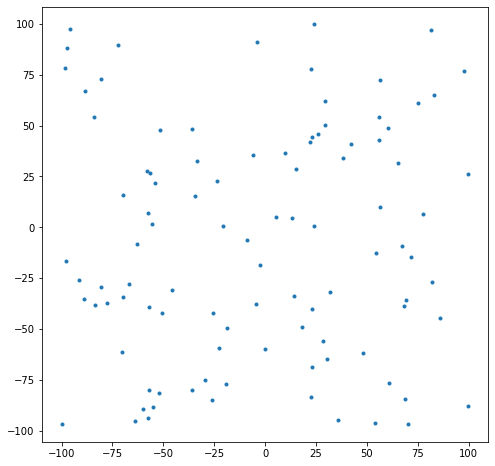

In [3]:
prepPlot()
plt.plot(*generateSetA())

## 2.b

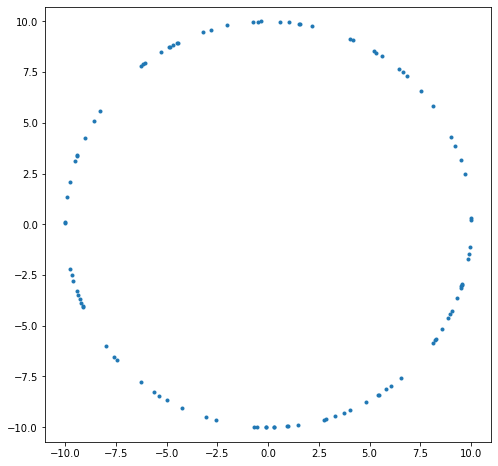

In [4]:
prepPlot()
plt.plot(*generateSetB())

## 2.c

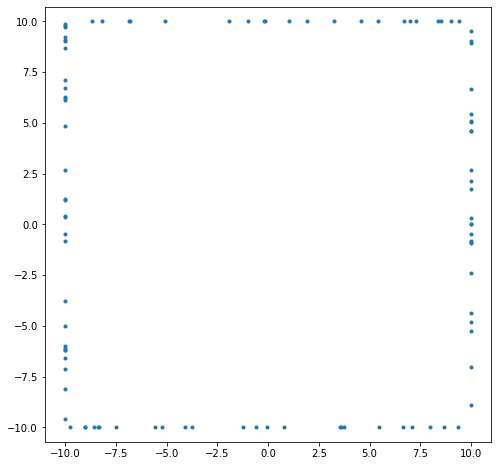

In [5]:
prepPlot()
plt.plot(*generateSetC())

## 2.d

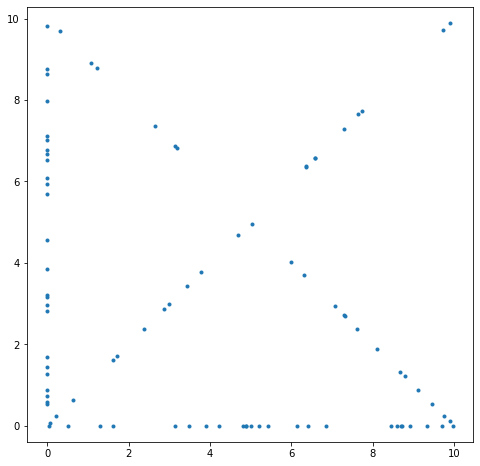

In [6]:
prepPlot()
plt.plot(*generateSetD())

# Funkcje pomocnicze

In [7]:
def higherOnRightCmp(p1, p2):
    return p2[1] - p1[1] if p1[1] != p2[1] else p2[0] - p1[0]

def detOwn3(p0, p1, p2):
    return p0[0] * p1[1] + p1[0] * p2[1] + p2[0] * p0[1] - p2[0] * p1[1] - p1[0] * p0[1] - p0[0] * p2[1]

def minIdxForCmp(src, cmp,):
    resIdx = 0
    
    for idx in range(0, len(src)):
        if cmp(src[resIdx], src[idx]) < 0:
            resIdx = idx
            
    return resIdx

def farther(p0, p1, p2):
    return (p2[0] - p0[0]) ** 2 + (p2[1] - p0[1]) ** 2 > (p1[0] - p0[0]) ** 2 + (p1[1] - p0[1]) ** 2

# Algorytm Jarvisa

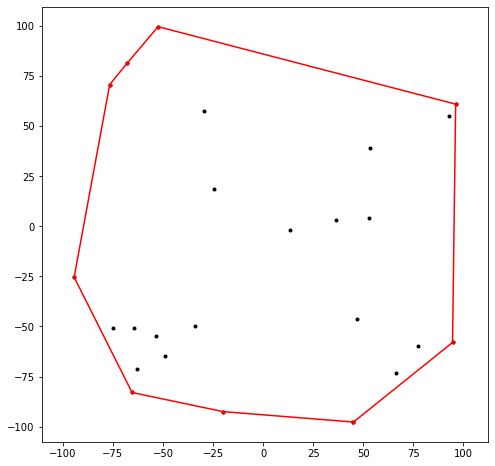

In [96]:
def jarvis(x, y, epsilon):
    x = x.copy()
    y = y.copy()
    
    points = list(zip(x, y))
    
    if len(points) < 4:
        resX, resY = map(np.array, zip(*points))
        return resX, resY
    
    lowestLeftmostIdx = minIdxForCmp(points, higherOnRightCmp)
    result = [points[lowestLeftmostIdx]]
    skipIdx = lowestLeftmostIdx
    
    iterations = 0
    while True:
        candIdx = 1 if skipIdx == 0 else 0
        
        for idx in range(0, len(points)):
            if idx != skipIdx:
                det = detOwn3(result[-1], points[candIdx], points[idx])
                if det < -epsilon or (abs(det) <= epsilon and farther(result[-1], points[candIdx], points[idx])):
                    candIdx = idx
                    
        skipIdx = candIdx
        result.append(points[candIdx])
        if result[0] == result[-1]:
            result.pop()
            break
        
        if iterations > len(points) + 2:
            raise Exception("looped! adjust epsilon")
            
    resX, resY = map(np.array, zip(*result))
    return resX, resY

def jarvisAnimated(x, y, epsilon, ax):
    points = list(zip(x, y))
    
    if len(points) < 4:
        frame = []
        
        frame.extend([*ax.plot(x, y, 'r.')])
        
        points.append(points[0])
        frame.extend([*ax.plot(*map(np.array, zip(*points)), 'g-')])
        
        return [frame]
    
    frames = []
    
    lowestLeftmostIdx = minIdxForCmp(points, higherOnRightCmp)
    result = [points[lowestLeftmostIdx]]
    skipIdx = lowestLeftmostIdx
    
    def plotResultHull():
        return [*ax.plot(*map(np.array, zip(*result)), 'g-', linewidth=3)]
    
    def plotPoints():
        return [*ax.plot(x, y, 'k.')]
    
    def plotResult():
        return [*ax.plot(*map(np.array, zip(*result)), 'go', markersize=7)]
    
    startFrame = [*plotPoints(), *plotResult()]
    frames.append(startFrame)
    
    iterations = 0
    while True:
        candIdx = 1 if skipIdx == 0 else 0
        frames.append([*plotResultHull(), *plotPoints(), *plotResult(), *ax.plot(*points[candIdx], 'bo', markersize=7)])
        
        for idx in range(0, len(points)):
            if idx != skipIdx:
                frames.append([*plotResultHull(), *ax.plot(*map(np.array, zip(*[result[-1], points[idx]])), 'r-', linewidth=1), *plotPoints(), *plotResult(), *ax.plot(*points[candIdx], 'bo', markersize=7)])
                det = detOwn3(result[-1], points[candIdx], points[idx])
                if det < -epsilon or (abs(det) <= epsilon and farther(result[-1], points[candIdx], points[idx])):
                    candIdx = idx
                    
        skipIdx = candIdx
        result.append(points[candIdx])
        frames.append([*plotResultHull(), *plotPoints(), *plotResult()])
        if result[0] == result[-1]:
            result.pop()
            break
        
        if iterations > len(points) + 2:
            raise Exception("looped! adjust epsilon")
            
    return frames
    
x, y = generateSetA(25)
xHull, yHull = jarvis(x, y, 10 ** -13)
xHull = np.append(xHull, xHull[0])
yHull = np.append(yHull, yHull[0])
prepPlot()
plt.plot(x, y, 'k')
plt.plot(xHull, yHull, 'r-')
plt.plot(xHull, yHull, 'r.')

In [97]:
%%capture
prepPlot()
fig, ax = plt.subplots()
ani = anim.ArtistAnimation(fig, jarvisAnimated(x, y, 10 ** -13, ax), interval=50)

In [98]:
ani